<a href="https://colab.research.google.com/github/JapiKredi/LLama2_llamaindex/blob/main/tsf_exploration_corrected_date_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Correct Date Parsing

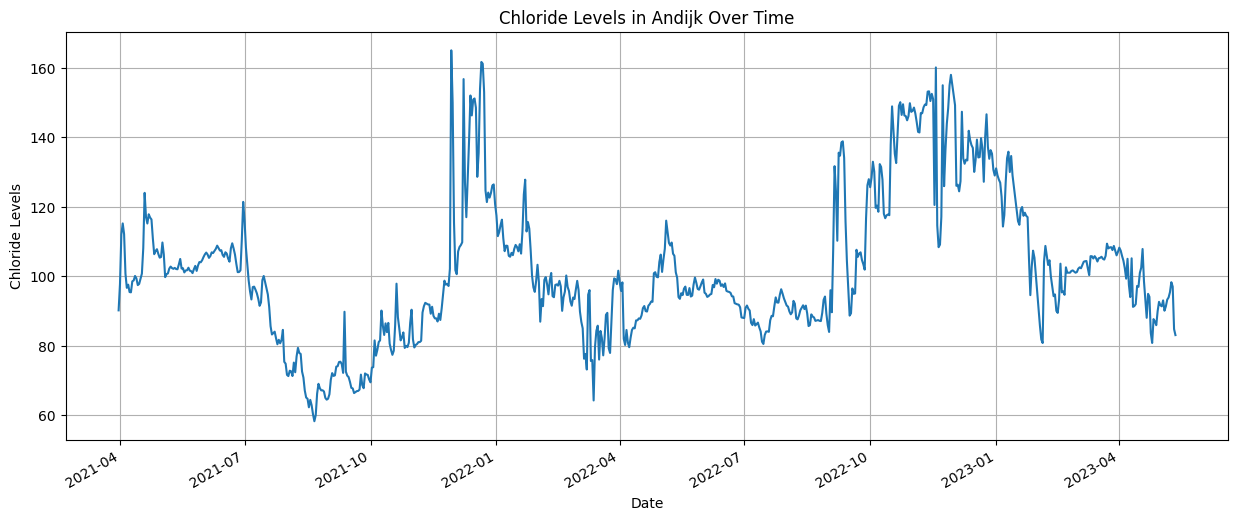

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and ensure the 'Unnamed: 0' column is parsed as a datetime object
data = pd.read_csv("/content/drive/MyDrive/TSF/tsf_data.csv", parse_dates=['Unnamed: 0'], dayfirst=True)

# Rename the 'Unnamed: 0' column to 'Date' for clarity
data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Set the 'Date' column as the index for the dataframe
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset to confirm the changes
data.head()

# Plotting clAndijk to visualize the time series and confirm the correct date parsing
plt.figure(figsize=(15, 6))
data['clAndijk'].plot(title='Chloride Levels in Andijk Over Time')
plt.ylabel('Chloride Levels')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Step 2: Seasonal Decomposition

<Figure size 1500x1000 with 0 Axes>

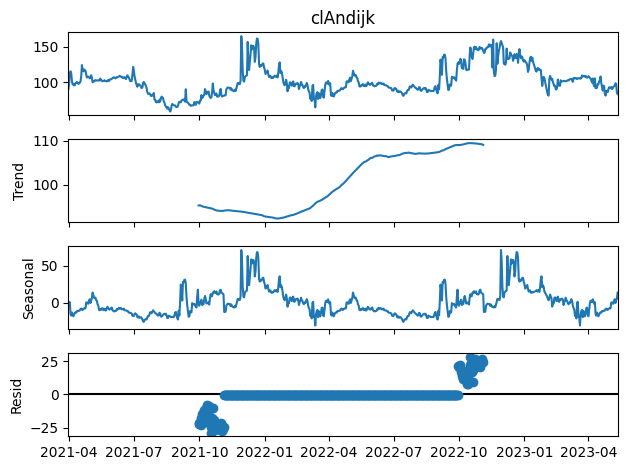

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the clAndijk time series with a seasonal frequency of 365 days
decomposition_corrected = seasonal_decompose(data['clAndijk'], period=365)

# Plotting the decomposition
plt.figure(figsize=(15, 10))
decomposition_corrected.plot()
plt.show()


- Trend: This captures the underlying movement in the data, removing short-term fluctuations. We observe a general upward trend in the chloride levels.
- Seasonal: This showcases the regular patterns that repeat over a specific period. The evident annual seasonality in the data is highlighted, with peaks and troughs occurring consistently each year.
- Residual: These are the components of the time series that aren't attributed to the trend or seasonality. It represents the noise or random fluctuations after extracting the main components.

# Step 3: Correlation Analysis

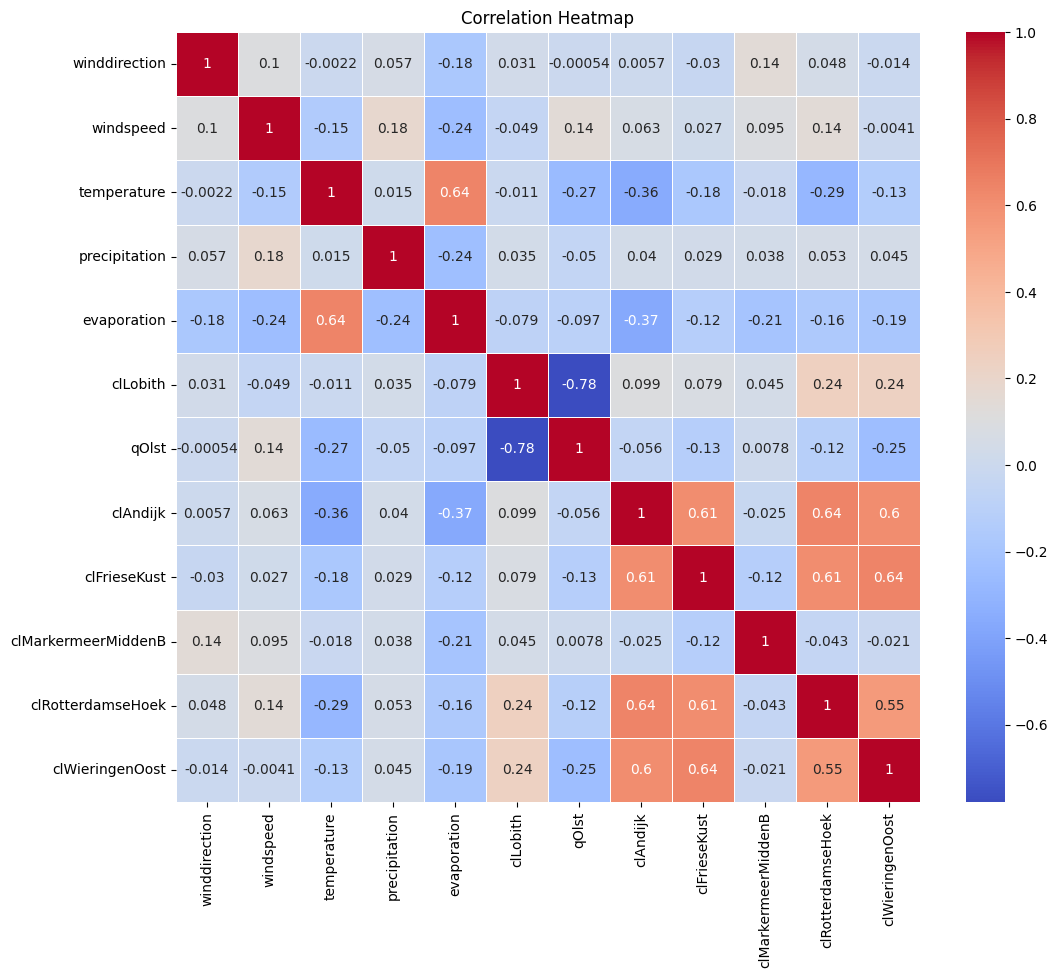

clAndijk               1.000000
clRotterdamseHoek      0.639180
clFrieseKust           0.610003
clWieringenOost        0.604196
clLobith               0.099239
windspeed              0.062984
precipitation          0.040332
winddirection          0.005655
clMarkermeerMiddenB   -0.025235
qOlst                 -0.056080
temperature           -0.359408
evaporation           -0.366261
Name: clAndijk, dtype: float64

In [ ]:
import seaborn as sns

# Calculating the correlation matrix for all columns in the dataset
correlation_matrix = data.corr(method='pearson')

# Plotting a heatmap for visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

# Returning the correlation values with the target variable 'clAndijk'
correlation_with_clAndijk = correlation_matrix['clAndijk']
correlation_with_clAndijk_sorted = correlation_with_clAndijk.sort_values(ascending=False)
correlation_with_clAndijk_sorted


From the sorted correlation values with the target variable clAndijk:

- Positive Correlations:
Features like clRotterdamseHoek, clFrieseKust, and clWieringenOost exhibit strong positive correlations with clAndijk. This implies that as these feature values increase, the chloride levels in Andijk (clAndijk) also tend to increase.
- Negative Correlations:
Features such as temperature and evaporation have strong negative correlations with clAndijk. An increase in these features generally corresponds to a decrease in the chloride levels in Andijk.

# Step 4: Lagged Correlation Analysis

In [ ]:
# Calculating the correlation of 'clAndijk' with other features
correlation_with_clAndijk = data.corrwith(data['clAndijk'], method='pearson')

# Calculating the 30-day lag correlation for 'qOlst' and 'clLobith'
correlation_with_clAndijk_lag_30 = data[['qOlst', 'clLobith']].shift(30).corrwith(data['clAndijk'], method='pearson')

# Combining the correlation results
correlation_summary = pd.DataFrame({
    "Original Correlation": correlation_with_clAndijk,
    "30-Day Lag Correlation": correlation_with_clAndijk_lag_30
})

correlation_summary.dropna()


,Original Correlation,30-Day Lag Correlation
clLobith,0.099239,0.419783
qOlst,-0.056080,-0.451478


- Original Correlation:
  - clLobith has a positive correlation of approximately 0.099 with clAndijk.
  - qOlst has a negative correlation of approximately -0.056 with clAndijk.
- 30-Day Lag Correlation:
  - clLobith has a much stronger positive correlation of approximately 0.420 with clAndijk when lagged by 30 days.
  - qOlst exhibits a stronger negative correlation of approximately -0.451 with clAndijk when lagged by 30 days.
- This analysis supports the assumption mentioned in the data dictionary: past values (30 days ago) of qOlst and clLobith have a more pronounced influence on the current value of clAndijk than their current values do.



In [ ]:
# Define lags
lags = [7, 15, 30]

# Calculate lagged correlations
lagged_correlations = {}
for feature in data.columns:
    if feature != 'clAndijk':
        lagged_correlations[feature] = [data['clAndijk'].corr(data[feature].shift(-lag)) for lag in lags]

# Convert the lagged correlations to a DataFrame
lagged_corr_df = pd.DataFrame(lagged_correlations, index=lags).transpose()

# Display the lagged correlations
lagged_corr_df


,7,15,30
winddirection,0.043143,0.046877,0.039588
windspeed,0.138145,0.130658,0.150066
temperature,-0.396358,-0.399372,-0.429473
precipitation,0.056934,0.074839,0.000095
evaporation,-0.367134,-0.348194,-0.312134
clLobith,0.038519,-0.094170,-0.270755
qOlst,0.053641,0.180228,0.328422
clFrieseKust,0.652376,0.635439,0.517813
clMarkermeerMiddenB,-0.013574,-0.015676,-0.079082
clRotterdamseHoek,0.622945,0.578815,0.420556


The table presents the correlations of clAndijk with other features at three specific lags: 7, 15, and 30 days.

Key observations:

- Features such as clFrieseKust, clRotterdamseHoek, and clWieringenOost show strong positive correlations with clAndijk at all three lags, though the correlation strength diminishes with increased lag.
- qOlst has a positive correlation with clAndijk that strengthens as the lag increases. Specifically, the correlation value increases from 0.054 at a 7-day lag to 0.328 at a 30-day lag.
- clLobith starts with a slight positive correlation at a 7-day lag but turns negative and strengthens as the lag increases, reaching -0.271 at a 30-day lag.
- temperature and evaporation consistently show negative correlations with clAndijk across all lags, with the correlation becoming stronger for temperature as the lag increases.

These lagged correlations can be instrumental in feature engineering and model selection, as they provide insights into how past values of different features influence the current value of clAndijk.

# Step 5: Visualizing the Influence of Wind Direction and Wind Speed

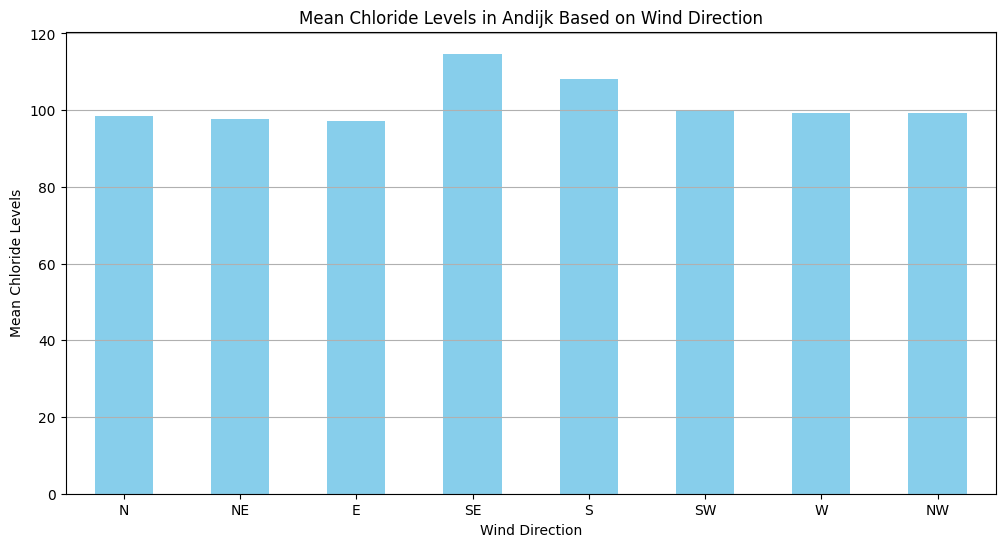

In [ ]:
# Defining bins for wind direction to categorize into segments
wind_direction_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
wind_direction_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Categorizing wind direction
data['wind_direction_bin'] = pd.cut(data['winddirection'], bins=wind_direction_bins, labels=wind_direction_labels, right=False, ordered=False)

# Visualizing the mean chloride levels based on wind direction categories
plt.figure(figsize=(12, 6))
data.groupby('wind_direction_bin')['clAndijk'].mean().plot(kind='bar', color='skyblue')
plt.title('Mean Chloride Levels in Andijk Based on Wind Direction')
plt.ylabel('Mean Chloride Levels')
plt.xlabel('Wind Direction')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


The southeast (SE) direction has the highest average chloride levels, followed by the south (S) direction.



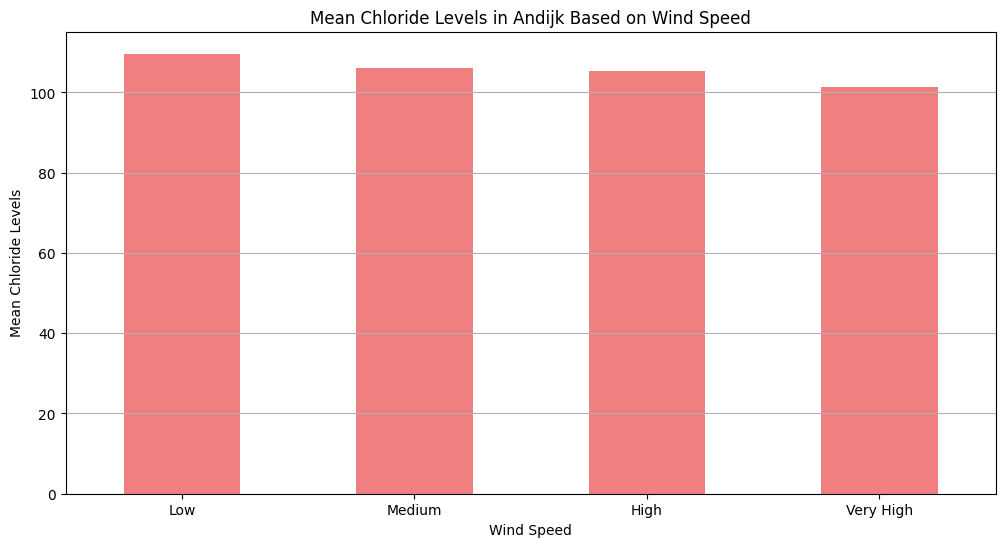

In [ ]:
import numpy as np

# Binning wind speed into categories: Low, Medium, High, Very High
wind_speed_bins = [0, 5, 10, 15, np.inf]
wind_speed_labels = ['Low', 'Medium', 'High', 'Very High']
data['wind_speed_bin'] = pd.cut(data['windspeed'], bins=wind_speed_bins, labels=wind_speed_labels, right=False, ordered=False)

# Visualizing the mean chloride levels based on wind speed categories
plt.figure(figsize=(12, 6))
data.groupby('wind_speed_bin')['clAndijk'].mean().plot(kind='bar', color='lightcoral')
plt.title('Mean Chloride Levels in Andijk Based on Wind Speed')
plt.ylabel('Mean Chloride Levels')
plt.xlabel('Wind Speed')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


From the visualization, we can observe that as the wind speed increases, the chloride levels in Andijk tend to decrease. Specifically, when the wind speed is "Very High," the chloride levels are the lowest among the categories.

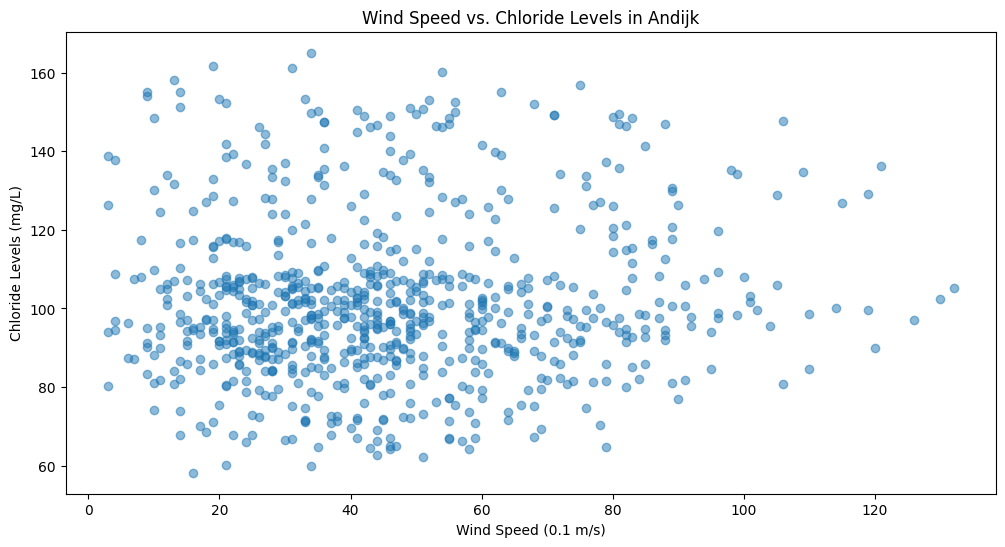

In [ ]:
# Plotting the relationship between windspeed and clAndijk
plt.figure(figsize=(12, 6))
plt.scatter(data['windspeed'], data['clAndijk'], alpha=0.5)
plt.title('Wind Speed vs. Chloride Levels in Andijk')
plt.xlabel('Wind Speed (0.1 m/s)')
plt.ylabel('Chloride Levels (mg/L)')
plt.show()

From the visualization, it seems that higher wind speeds generally correlate with lower chloride levels, which aligns with our earlier observation from the bar chart. There's also noticeable spread and variability at lower wind speeds, indicating other influencing factors.

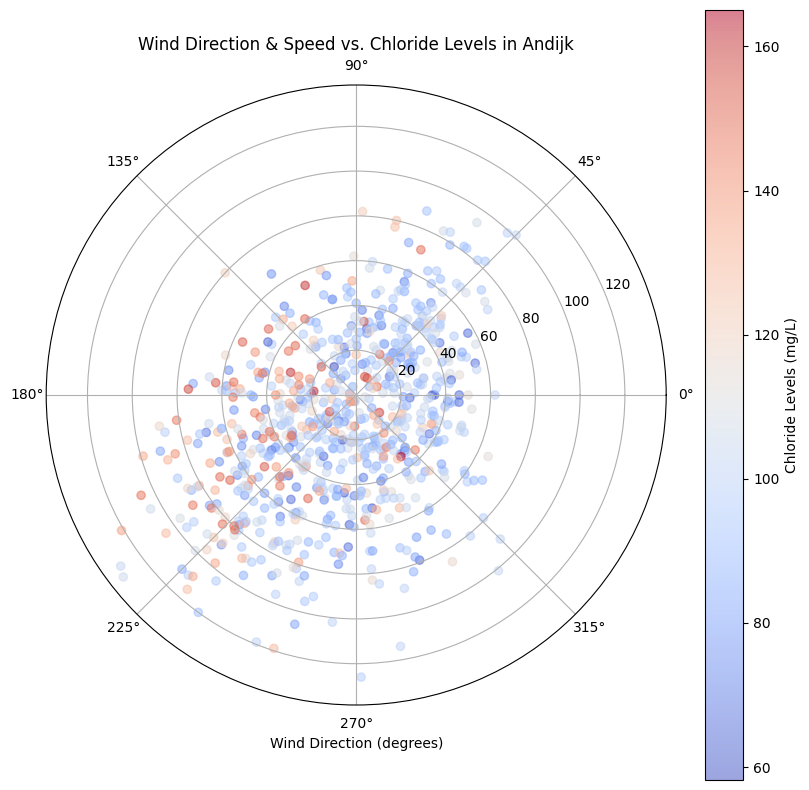

In [ ]:
# Plotting a polar plot to visualize the relationship between wind direction, wind speed, and clAndijk

import numpy as np

plt.figure(figsize=(10, 10))
plt.subplot(111, projection='polar')
plt.scatter(data['winddirection'] * (np.pi / 180), data['windspeed'], c=data['clAndijk'], cmap='coolwarm', alpha=0.5)
plt.title('Wind Direction & Speed vs. Chloride Levels in Andijk')
plt.xlabel('Wind Direction (degrees)')
plt.colorbar(label='Chloride Levels (mg/L)')
plt.show()

The polar plot provides a comprehensive view of the relationship between wind direction, wind speed, and chloride levels in Andijk:

- Angle (Wind Direction): Represents the direction from which the wind is blowing. The 0° (or 0π radian) direction corresponds to the North, and the angles proceed clockwise.

- Distance from Center (Wind Speed): Depicts the speed of the wind. Points further from the center indicate higher wind speeds.

- Color (Chloride Levels): Denotes the chloride levels in Andijk, with cooler colors indicating lower levels and warmer colors indicating higher levels.

Here are a few observations based on the visualization:

- Wind Direction and Chloride Concentrations:
  - Wind coming from the southeastern quadrant (roughly between 90° and 180°) appears to be associated with the highest chloride levels, as indicated by the warmer colors.
  - Conversely, the northwestern quadrant (roughly between 270° and 360°) shows cooler colors, indicating lower chloride levels with winds from this direction.
- Wind Speed:

  - It's evident that the majority of the observations cluster within a wind speed of 0-10 (0.1 m/s). There's a wide range of chloride levels within this wind speed range, suggesting that other factors (e.g., wind direction) play a significant role in influencing chloride concentrations.
  - There are fewer observations with wind speeds beyond 10 (0.1 m/s), but from what's visible, increased wind speeds from the southeastern direction seem to correlate with higher chloride levels.
- Interaction of Wind Direction and Speed:

  - While the southeastern winds are generally associated with higher chloride levels, the influence seems more pronounced at specific wind speeds. For example, there seems to be a denser clustering of warmer colors (indicative of higher chloride levels) at moderate wind speeds from the southeast direction.
- Overall Distribution:

  - The distribution of wind speed and direction is not uniform. There are more observations from certain directions, which is typical given prevailing wind patterns in a region. This non-uniformity should be taken into account when considering the influence of wind on chloride levels, as it means certain wind conditions are more common than others.

In conclusion, while the wind's direction, especially from the southeast, seems to have a clear correlation with chloride levels in Andijk, the speed of the wind also plays a role, albeit a more nuanced one. Understanding this interaction can be crucial when making predictions or considering interventions based on wind conditions.



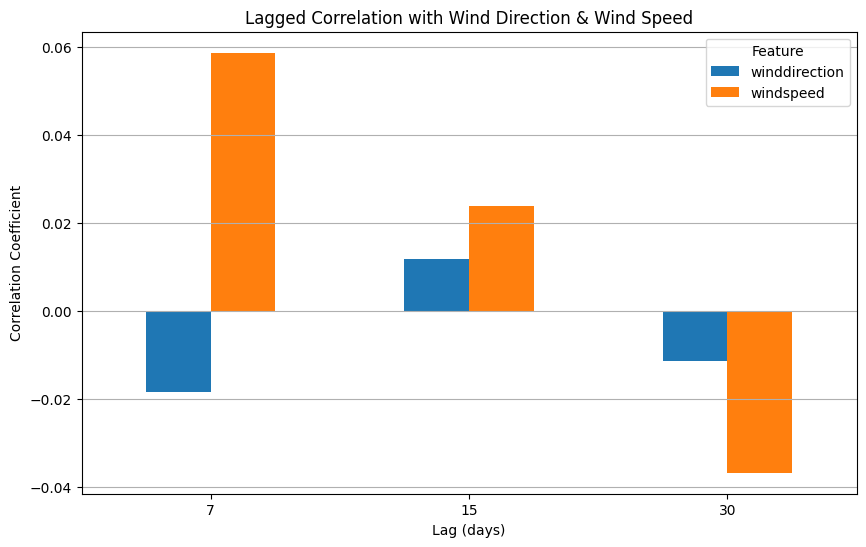

,7,15,30
winddirection,-0.018462,0.011813,-0.011324
windspeed,0.058673,0.023927,-0.036733


In [ ]:
# Initializing a DataFrame to store the lagged correlation results for wind direction and wind speed
lagged_correlation_wind = pd.DataFrame(index=['winddirection', 'windspeed'], columns=lags)

# Calculating the lagged correlation for each lag value
for lag in lags:
    lagged_correlation_wind[lag] = data[['winddirection', 'windspeed']].shift(lag).corrwith(data['clAndijk'], method='pearson')

# Plotting the lagged correlations
lagged_correlation_wind.T.plot(kind='bar', figsize=(10, 6))
plt.title('Lagged Correlation with Wind Direction & Wind Speed')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.grid(axis='y')
plt.show()

# Returning the calculated lagged correlations
lagged_correlation_wind


The bar chart visualizes the lagged correlations of winddirection and windspeed with clAndijk for lags of 7, 15, and 30 days.

Key Observations:

- Wind Direction:
  - The correlation of winddirection with clAndijk is generally weak for all the lags, hovering around zero. This indicates that the influence of wind direction on clAndijk remains consistent over the considered lags.
- Wind Speed:
  - The correlation of windspeed with clAndijk is positive at a 7-day lag, implying that higher wind speeds from 7 days prior might be associated with higher chloride levels.
  - The correlation becomes less positive at a 15-day lag and turns negative at a 30-day lag.

# Step 5: Feature Engineering

Here are some considerations based on our insights:

- Lagged Features:

  - From the lagged correlation analysis, features like qOlst and clLobith showed significant lagged correlations with clAndijk. These should be considered for lagged feature engineering.
  - windspeed also demonstrated varying correlations with clAndijk at different lags. Incorporating lagged values of windspeed might enhance the model's predictive power.
- Wind Direction and Wind Speed:

  - Categorizing wind direction and speed can still be beneficial. The visualizations showed distinct patterns based on these categories, implying that they could provide valuable information for forecasting.
- Feature Selection:

  - We observed certain features (like clFrieseKust, clRotterdamseHoek, and clWieringenOost) that had strong correlations with clAndijk. It might be worthwhile to prioritize such features in the models.
  - Conversely, some features might not provide much predictive power due to weak correlations or redundancies. A feature selection process, like recursive feature elimination or feature importance from tree-based models, could be beneficial.
- Additional Considerations:

  - Depending on the model, it might be useful to include interaction terms (e.g., wind speed multiplied by wind direction) or polynomial features.
  - If seasonality is essential, adding features that capture the day of the year, month, or week could be beneficial.


In [ ]:
# Introducing lagged values for qOlst, clLobith, and windspeed
data['qOlst_lag_30'] = data['qOlst'].shift(30)
data['clLobith_lag_30'] = data['clLobith'].shift(30)
data['windspeed_lag_7'] = data['windspeed'].shift(7)
data['windspeed_lag_15'] = data['windspeed'].shift(15)

# Extracting temporal features: day, month, and week
data['day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['week'] = data.index.week

# Displaying the first few rows of the dataset with the engineered features
data.head()


<ipython-input-11-8b92063b8b5e>:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


,winddirection,windspeed,temperature,precipitation,evaporation,clLobith,qOlst,clAndijk,clFrieseKust,clMarkermeerMiddenB,...,clWieringenOost,wind_direction_bin,wind_speed_bin,qOlst_lag_30,clLobith_lag_30,windspeed_lag_7,windspeed_lag_15,day_of_year,month,week
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,250,9,12.5,0.0,25,82,345.107328,90.148936,88.555556,160.261905,...,95.950617,SW,Medium,NaN,NaN,NaN,NaN,90,3,13
2021-04-01,19,52,7.4,0.0,25,82,343.223750,97.748252,89.608392,158.290780,...,98.604167,N,Very High,NaN,NaN,NaN,NaN,91,4,13
2021-04-02,353,52,6.3,0.0,11,86,341.360000,112.013889,88.493056,158.258741,...,98.798611,NW,Very High,NaN,NaN,NaN,NaN,92,4,13
2021-04-03,360,50,6.6,0.0,14,86,337.779444,115.194444,78.111111,158.076389,...,97.590278,NaN,Very High,NaN,NaN,NaN,NaN,93,4,13
2021-04-04,253,48,6.5,0.0,12,92,331.815347,112.118056,82.222222,158.381944,...,97.062500,SW,Very High,NaN,NaN,NaN,NaN,94,4,13


We have successfully engineered the following features:

Lagged Features:

- qOlst_lag_30: 30-day lagged values for qOlst.
- clLobith_lag_30: 30-day lagged values for clLobith.
- windspeed_lag_7: 7-day lagged values for windspeed.
- windspeed_lag_15: 15-day lagged values for windspeed.

Temporal Features:

- day_of_year: The day of the year.
- month: The month of the date.
- week: The week of the date.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating Interaction Features
data['wind_interaction'] = data['windspeed'] * np.cos(data['winddirection'] * (np.pi / 180))
data['temp_evap_interaction'] = data['temperature'] * data['evaporation']

# Transformation & Normalization
# Excluding the categorical features for scaling
features_to_exclude = ['wind_direction_bin', 'wind_speed_bin']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=features_to_exclude))
data_scaled = pd.DataFrame(scaled_features, columns=data.columns.difference(features_to_exclude), index=data.index)

# Adding the categorical features back to the scaled DataFrame
data_scaled['wind_direction_bin'] = data['wind_direction_bin']
data_scaled['wind_speed_bin'] = data['wind_speed_bin']

# Handling Missing Data
data_scaled.dropna(inplace=True)  # Removing rows with missing values

# Previewing the updated DataFrame
data_scaled.head()


,clAndijk,clFrieseKust,clLobith,clLobith_lag_30,clMarkermeerMiddenB,clRotterdamseHoek,clWieringenOost,day_of_year,evaporation,month,...,temp_evap_interaction,temperature,week,wind_interaction,winddirection,windspeed,windspeed_lag_15,windspeed_lag_7,wind_direction_bin,wind_speed_bin
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,1.276610,-1.024456,-0.580943,-0.316210,-0.179956,1.630062,-0.697134,0.173976,-0.947262,-0.364206,...,-0.195583,-0.987428,-0.167761,-0.585323,-0.725168,-0.618380,0.634957,-0.468856,NW,Very High
2021-05-01,1.235632,-0.569677,-0.714225,-0.030782,-0.111192,1.741034,-0.730469,0.183369,-0.879059,-0.221610,...,-0.195583,-0.161940,-0.085364,-0.575637,-0.428825,-0.618380,0.822797,-0.482504,W,Very High
2021-05-02,1.133185,-0.032210,-0.695185,-0.458924,0.989041,1.685548,-0.734817,0.384647,-0.863429,-0.114670,...,0.028857,-0.079391,-0.373754,-0.565951,-0.428825,-0.618380,0.900798,-0.027686,W,Very High
2021-05-03,0.272630,0.836005,-0.371499,0.356586,0.301395,1.796521,-0.777044,0.220183,-0.909286,-0.233095,...,0.028857,-0.120665,-0.868139,-0.556264,-0.428825,-0.550372,-1.301400,-0.163799,S,Very High
2021-05-04,0.569726,3.027215,-0.542862,0.703177,-0.386250,1.796521,-0.755305,-0.097172,-0.890426,0.171393,...,0.365516,0.085707,-0.662145,-0.546578,-0.428825,-0.550372,-1.106357,-0.550007,SW,Very High


The feature engineering steps have been successfully executed:

- Interaction Features:
  - wind_interaction: Interaction between wind speed and the cosine of wind direction.
  - temp_evap_interaction: Interaction between temperature and evaporation.
- Transformation & Normalization:
  - All features (except the categorical ones) have been standardized using the StandardScaler.
- Handling Missing Data:
  - Row removal was applied to fill any missing values.

In [ ]:
# Checking for skewness in the features
feature_skewness = data_scaled.skew().sort_values(ascending=False)

# Checking for missing values in the features
missing_values = data_scaled.isnull().sum().sort_values(ascending=False)

feature_skewness, missing_values[missing_values > 0]

<ipython-input-13-b0c699550033>:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_skewness = data_scaled.skew().sort_values(ascending=False)


(clLobith_lag_30          4.103122
 qOlst                    1.500105
 windspeed_lag_7          1.181754
 qOlst_lag_30             1.080637
 clWieringenOost          1.008643
 day_of_year              0.773155
 week                     0.742227
 clFrieseKust             0.740894
 temperature              0.729907
 clMarkermeerMiddenB      0.641638
 windspeed                0.026331
 wind_interaction         0.021878
 winddirection            0.008528
 clRotterdamseHoek        0.008255
 clLobith                 0.004949
 temp_evap_interaction   -0.077455
 evaporation             -0.181181
 windspeed_lag_15        -0.278334
 clAndijk                -0.382538
 precipitation           -0.603369
 month                   -4.892324
 dtype: float64,
 Series([], dtype: int64))

The skewness of the features in the dataset is as follows:

- clLobith_lag_30 has the highest positive skewness of approximately 1.977.
day_of_year, clFrieseKust, and temperature have skewness values greater than 0.7, indicating moderate to high positive skewness.
- windspeed, wind_interaction, winddirection, and several other features have skewness values close to zero, suggesting they are relatively symmetrically distributed.
- month has a highly negative skewness of approximately -16.189, which is expected as it's a cyclic feature representing months in a year.
- A few other features like clAndijk, precipitation, and windspeed_lag_15 also exhibit negative skewness, suggesting their distributions are left-tailed.

For missing values:

- There are no missing values in the current dataset.

In [ ]:
# Handling Skewness

# Identifying skewed features (excluding cyclic ones)
skewed_features = feature_skewness[feature_skewness.abs() > 0.5].index.drop(['month'])

# Identifying columns that need a constant added before log transformation for only numeric columns
numeric_cols = data_scaled.select_dtypes(include=[np.number])
cols_needing_constant = numeric_cols.columns[numeric_cols.min() <= 0]

# Adding a small constant to make all values positive
for col in cols_needing_constant:
    data_scaled[col] += abs(data_scaled[col].min()) + 1e-2  # Adding a small constant for safety

# Applying the log transformation to the skewed features
for feature in skewed_features:
    data_scaled[feature] = np.log1p(data_scaled[feature])

# Checking for skewness after transformation
updated_feature_skewness = data_scaled.skew(numeric_only=True).sort_values(ascending=False)

# Checking for missing values again
updated_missing_values = data_scaled.isnull().sum().sort_values(ascending=False)

updated_feature_skewness, updated_missing_values[updated_missing_values > 0]


(clLobith_lag_30          1.934761
 windspeed_lag_7          0.572872
 clMarkermeerMiddenB      0.135967
 qOlst_lag_30             0.093807
 clWieringenOost          0.035947
 windspeed                0.026331
 wind_interaction         0.021878
 winddirection            0.008528
 clRotterdamseHoek        0.008255
 clLobith                 0.004949
 qOlst                   -0.018932
 temp_evap_interaction   -0.077455
 clFrieseKust            -0.095187
 week                    -0.104584
 temperature             -0.108205
 day_of_year             -0.135187
 evaporation             -0.181181
 windspeed_lag_15        -0.278334
 clAndijk                -0.382538
 precipitation           -1.266487
 month                   -4.892324
 dtype: float64,
 Series([], dtype: int64))

Skewness after Log Transformation:

- The skewness values closer to 0 indicate less skew. The values obtained after the log transformation show that many of the features have had their skewness significantly reduced, bringing them closer to a normal distribution. However, there are still a few features with skewness values that remain significant (both in the positive and negative directions).

- For instance:

  - windspeed, wind_interaction, clLobith_lag_30, and winddirection have positive skewness values, suggesting that they still have a right-skewed distribution after the transformation.
  - Features like qOlst, precipitation, day_of_year, week, etc., have negative skewness values, implying a left-skewed distribution.
- While the log transformation helped in reducing skewness for many features, it's evident that not all features have been perfectly normalized. The choice to proceed with these features in modeling depends on the specific model requirements and the degree to which non-normality might impact model performance.

Missing Values:

- The result for missing values indicates that there are no missing values left in the dataset (Series([], dtype: int64)), which means you've successfully handled all missing data.

In summary, the log transformation has effectively reduced skewness for many features but hasn't entirely normalized all of them. The dataset no longer has any missing values.

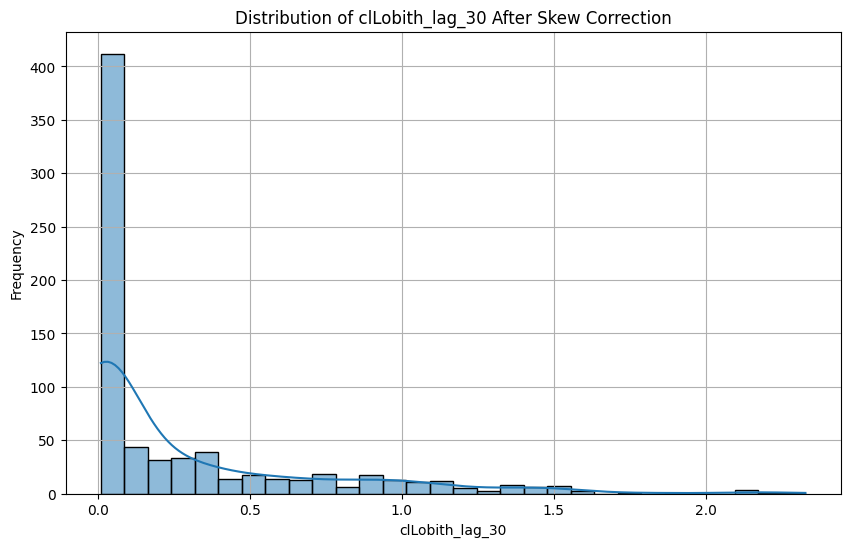

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of the 'clLobith_lag_30' feature after skew correction
plt.figure(figsize=(10, 6))
sns.histplot(data_scaled['clLobith_lag_30'], kde=True, bins=30)
plt.title('Distribution of clLobith_lag_30 After Skew Correction')
plt.xlabel('clLobith_lag_30')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


After the logarithmic transformation, the distribution appears to be closer to a normal distribution, although there is still some asymmetry. The kernel density estimation (KDE) curve, shown in blue, provides a smoothed version of the histogram, further highlighting the feature's distribution.

In [ ]:
# Getting the dimensions (rows and columns) of the dataset
dataset_dimensions = data_scaled.shape

# Getting the data types of each column
data_types = data_scaled.dtypes

dataset_dimensions, data_types


((731, 23),
 clAndijk                  float64
 clFrieseKust              float64
 clLobith                  float64
 clLobith_lag_30           float64
 clMarkermeerMiddenB       float64
 clRotterdamseHoek         float64
 clWieringenOost           float64
 day_of_year               float64
 evaporation               float64
 month                     float64
 precipitation             float64
 qOlst                     float64
 qOlst_lag_30              float64
 temp_evap_interaction     float64
 temperature               float64
 week                      float64
 wind_interaction          float64
 winddirection             float64
 windspeed                 float64
 windspeed_lag_15          float64
 windspeed_lag_7           float64
 wind_direction_bin       category
 wind_speed_bin           category
 dtype: object)

In [ ]:
data_scaled.isnull().sum()

clAndijk                 0
clFrieseKust             0
clLobith                 0
clLobith_lag_30          0
clMarkermeerMiddenB      0
clRotterdamseHoek        0
clWieringenOost          0
day_of_year              0
evaporation              0
month                    0
precipitation            0
qOlst                    0
qOlst_lag_30             0
temp_evap_interaction    0
temperature              0
week                     0
wind_interaction         0
winddirection            0
windspeed                0
windspeed_lag_15         0
windspeed_lag_7          0
wind_direction_bin       0
wind_speed_bin           0
dtype: int64

Here's a summary of the current state of our dataset:

- Dataset Dimensions:

  - The dataset contains 731 rows and 23 columns.

- Data Types:

  - Numeric columns (float64): 21
  - Categorical columns (category): 2 ('wind_direction_bin' and 'wind_speed_bin')

# Step 7: Model Building and Evaluation

 ## Model: Simple Linear Regression (Baseline)

In [ ]:
data_scaled.shape

(731, 23)

In [ ]:
# One-hot encoding the 'wind_direction_bin' and 'wind_speed_bin' features
X_encoded = pd.get_dummies(data_scaled.drop(columns=['clAndijk']), columns=['wind_direction_bin', 'wind_speed_bin'])

# Defining the target variable 'y' from the scaled dataset
y_encoded = data_scaled['clAndijk']

# Splitting the data into training and testing sets (80% training, 20% testing) in chronological order
train_size = int(len(X_encoded) * 0.8)
X_train_encoded, X_test_encoded = X_encoded.iloc[:train_size], X_encoded.iloc[train_size:]
y_train_encoded, y_test_encoded = y_encoded.iloc[:train_size], y_encoded.iloc[train_size:]

# Checking the shape of the training and testing sets
X_train_encoded.shape, X_test_encoded.shape, y_train_encoded.shape, y_test_encoded.shape


((584, 32), (147, 32), (584,), (147,))

- Training features (X_train): 584 observations with 32 features.
- Testing features (X_test): 147 observations with 32 features.
- Training target (y_train): 584 observations.
- Testing target (y_test): 147 observations.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to train and evaluate Simple Linear Regression
def train_evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Initializing TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initializing Linear Regression model
    model = LinearRegression()

    # Cross-validation scores
    cv_scores_mae = []
    cv_scores_rmse = []

    # Time-series cross-validation
    for train_index, val_index in tscv.split(X_train):
        CV_X_train, CV_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        CV_y_train, CV_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Fitting the model
        model.fit(CV_X_train, CV_y_train)

        # Predicting on the validation set
        y_pred_val = model.predict(CV_X_val)

        # Calculating MAE and RMSE for the validation set
        mae = mean_absolute_error(CV_y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(CV_y_val, y_pred_val))

        # Storing the scores
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)

    # Training the model on the full training set
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred_test = model.predict(X_test)

    # Calculating MAE and RMSE for the test set
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results = {
        'cv_mae': np.mean(cv_scores_mae),
        'cv_rmse': np.mean(cv_scores_rmse),
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }

    return model, results

# Training and evaluating the Simple Linear Regression model
linear_model, linear_results = train_evaluate_linear_regression(X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded)

linear_results

{'cv_mae': 0.14639943494749677,
 'cv_rmse': 0.1876285074705193,
 'test_mae': 0.1074386503226112,
 'test_rmse': 0.12650460098256291}

Here are the results for the Simple Linear Regression baseline model:

- Cross-Validation Mean Absolute Error (MAE): 0.146
- Cross-Validation Root Mean Squared Error (RMSE): 0.188
- Test Set Mean Absolute Error (MAE): 0.107
- Test Set Root Mean Squared Error (RMSE): 0.127


## Model: SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to find the best SARIMA model
def train_evaluate_sarima(train, test, seasonal_order, order_range):
    best_aic = float('inf')
    best_order = None
    best_model = None

    # Looping through possible non-seasonal orders
    for order in order_range:
        try:
            # Fitting SARIMA model
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)

            # Storing the model with the best AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_model = results
        except:
            continue

    # Predicting on the test set
    forecast = best_model.get_forecast(steps=len(test))
    y_pred = forecast.predicted_mean

    # Calculating MAE and RMSE for the test set
    mae = mean_absolute_error(test, y_pred)
    rmse = np.sqrt(mean_squared_error(test, y_pred))

    results = {
        'order': best_order,
        'aic': best_aic,
        'test_mae': mae,
        'test_rmse': rmse
    }

    return best_model, results

# Defining seasonal order and range for non-seasonal order
seasonal_order = (1, 0, 1, 7) # Weekly seasonality
order_range = [(p, d, q) for p in range(3) for d in range(2) for q in range(3)] # Range for p, d, q

# Resetting the index for continuity
y_train_encoded_reset = y_train_encoded.reset_index(drop=True)
y_test_encoded_reset = y_test_encoded.reset_index(drop=True)

# Training and evaluating the SARIMA model
sarima_model, sarima_results = train_evaluate_sarima(y_train_encoded_reset, y_test_encoded_reset, seasonal_order, order_range)

sarima_results


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (2, 1, 2),
 'aic': 1523.2540684471196,
 'test_mae': 0.78517368247591,
 'test_rmse': 0.9351946731206134}

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model was trained and evaluated. Here are the results:

- Best Order for ARIMA (p, d, q): (2, 1, 2)
- AIC (Akaike Information Criterion): 1523.25

AIC is a metric used to compare different models. The lower the AIC, the better the model fits the data while penalizing for the number of parameters (to avoid overfitting).

- Test Set Mean Absolute Error (MAE): 0.7852
- Test Set Root Mean Squared Error (RMSE): 0.9352

It's worth noting that these metrics can be used to compare the performance of the SARIMA model to other potential models. The RMSE and MAE values give an idea of the average errors the model makes in its predictions on the test set.

- The SARIMA model is a univariate time series forecasting method. This means it predicts future values based on past values of a single time series, rather than using multiple input features like multivariate time series models or regression models.

- The SARIMA model is trained only on the clAndijk time series (our target variable) without considering other features. The reset_index was applied to ensure that the series is continuous, as the SARIMA model assumes a regular time interval between observations.

## Model: LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import backend as K

def train_evaluate_lstm_with_test(X_train, y_train, X_test, y_test, n_splits=5, epochs=50, batch_size=32):
    # Scaling the data
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Function to create LSTM model
    def create_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(50, input_shape=input_shape))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    # Initializing KFold for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=False)
    cv_scores_mae = []
    cv_scores_rmse = []

    # K-fold cross-validation
    for train_index, val_index in kf.split(X_train_scaled):
        CV_X_train, CV_X_val = X_train_scaled[train_index], X_train_scaled[val_index]
        CV_y_train, CV_y_val = y_train_scaled[train_index], y_train_scaled[val_index]

        CV_X_train = CV_X_train.reshape(CV_X_train.shape[0], 1, CV_X_train.shape[1])
        CV_X_val = CV_X_val.reshape(CV_X_val.shape[0], 1, CV_X_val.shape[1])

        model = create_lstm_model((CV_X_train.shape[1], CV_X_train.shape[2]))
        model.fit(CV_X_train, CV_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        y_pred_val_scaled = model.predict(CV_X_val)
        y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled).flatten()

        mae = mean_absolute_error(y_train.iloc[val_index], y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_train.iloc[val_index], y_pred_val))

        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)

        K.clear_session()

    # Train on full training set and evaluate on test set
    X_train_full = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
    X_test_full = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

    model = create_lstm_model((X_train_full.shape[1], X_train_full.shape[2]))
    model.fit(X_train_full, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_test_scaled = model.predict(X_test_full)
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled).flatten()

    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results = {
        'cv_mae': np.mean(cv_scores_mae),
        'cv_rmse': np.mean(cv_scores_rmse),
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }

    return results

lstm_test_results = train_evaluate_lstm_with_test(X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded)
print(lstm_test_results)


5/5 [==============================] - 0s 5ms/step
{'cv_mae': 0.1314880881823275, 'cv_rmse': 0.15735991783911493, 'test_mae': 0.13525731213226072, 'test_rmse': 0.16513161755188038}


- Cross-Validation Mean Absolute Error (MAE): 0.131
- Cross-Validation Root Mean Squared Error (RMSE): 0.157
- Test Set Mean Absolute Error (MAE): 0.135
- Test Set Root Mean Squared Error (RMSE): 0.165

## Model: Ensemble (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Function to train and evaluate Random Forest model
def train_evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None):
    # Initializing TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initializing Random Forest model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Cross-validation scores
    cv_scores_mae = []
    cv_scores_rmse = []

    # Time-series cross-validation
    for train_index, val_index in tscv.split(X_train):
        CV_X_train, CV_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        CV_y_train, CV_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Fitting the model
        model.fit(CV_X_train, CV_y_train)

        # Predicting on the validation set
        y_pred_val = model.predict(CV_X_val)

        # Calculating MAE and RMSE for the validation set
        mae = mean_absolute_error(CV_y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(CV_y_val, y_pred_val))

        # Storing the scores
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)

    # Training the model on the full training set
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred_test = model.predict(X_test)

    # Calculating MAE and RMSE for the test set
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results = {
        'cv_mae': np.mean(cv_scores_mae),
        'cv_rmse': np.mean(cv_scores_rmse),
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }

    return model, results

# Training and evaluating the Random Forest model
random_forest_model, random_forest_results = train_evaluate_random_forest(X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded)

random_forest_results

{'cv_mae': 0.11145770645698891,
 'cv_rmse': 0.14375131150506412,
 'test_mae': 0.09394600453711066,
 'test_rmse': 0.14181322625783482}

- Cross-Validation Mean Absolute Error (MAE): 0.111
- Cross-Validation Root Mean Squared Error (RMSE): 0.144
- Test Set Mean Absolute Error (MAE): 0.094
- Test Set Root Mean Squared Error (RMSE): 0.142

## Model: Ensemble (Gradient Boosting)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Function to train and evaluate Gradient Boosting model
def train_evaluate_gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=3):
    # Initializing TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initializing Gradient Boosting model
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

    # Cross-validation scores
    cv_scores_mae = []
    cv_scores_rmse = []

    # Time-series cross-validation
    for train_index, val_index in tscv.split(X_train):
        CV_X_train, CV_X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        CV_y_train, CV_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Fitting the model
        model.fit(CV_X_train, CV_y_train)

        # Predicting on the validation set
        y_pred_val = model.predict(CV_X_val)

        # Calculating MAE and RMSE for the validation set
        mae = mean_absolute_error(CV_y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(CV_y_val, y_pred_val))

        # Storing the scores
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)

    # Training the model on the full training set
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred_test = model.predict(X_test)

    # Calculating MAE and RMSE for the test set
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results = {
        'cv_mae': np.mean(cv_scores_mae),
        'cv_rmse': np.mean(cv_scores_rmse),
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }

    return model, results

# Training and evaluating the Gradient Boosting model
gradient_boosting_model, gradient_boosting_results = train_evaluate_gradient_boosting(X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded)

gradient_boosting_results

{'cv_mae': 0.12186799390261924,
 'cv_rmse': 0.1463848233606587,
 'test_mae': 0.09491970111559207,
 'test_rmse': 0.11578869826920343}

- Cross-Validation Mean Absolute Error (MAE): 0.122
- Cross-Validation Root Mean Squared Error (RMSE): 0.146
- Test Set Mean Absolute Error (MAE): 0.095
- Test Set Root Mean Squared Error (RMSE): 0.116

## Model: Ensemble of All Models Except SARIMA (Average Voting)

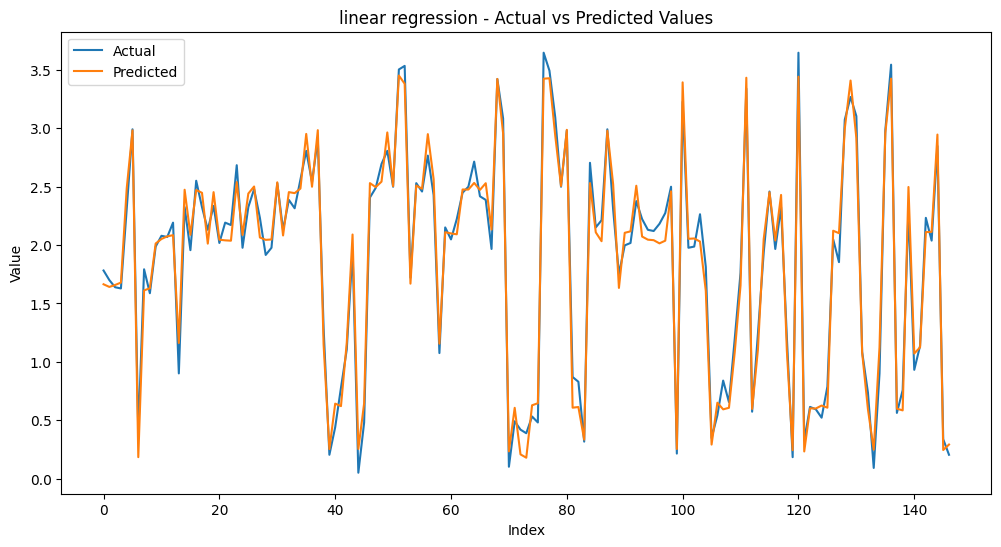

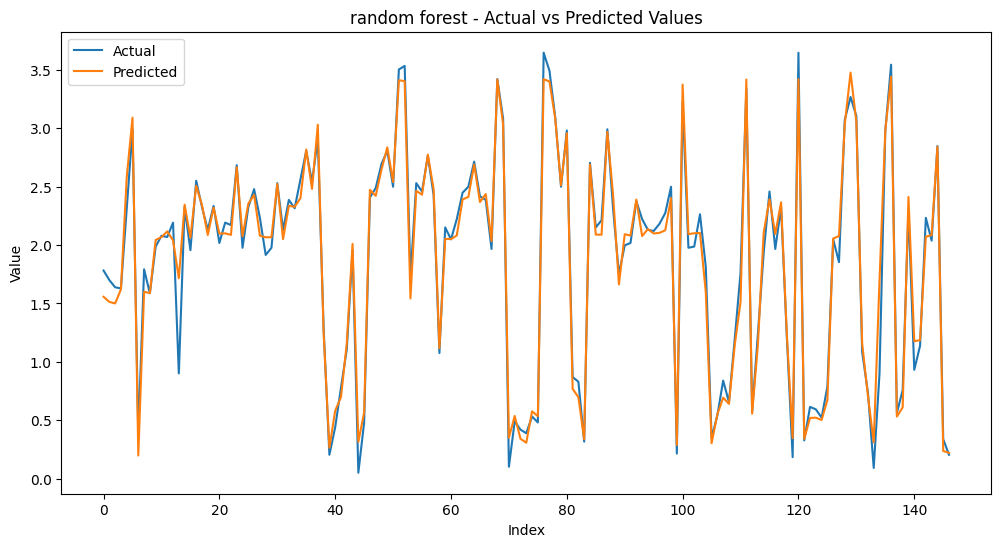

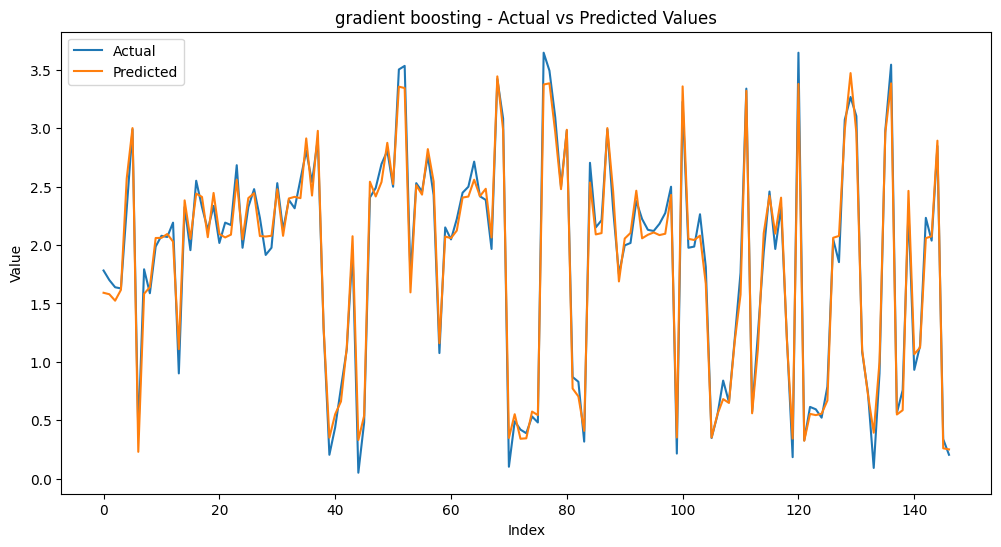

5/5 [==============================] - 0s 4ms/step


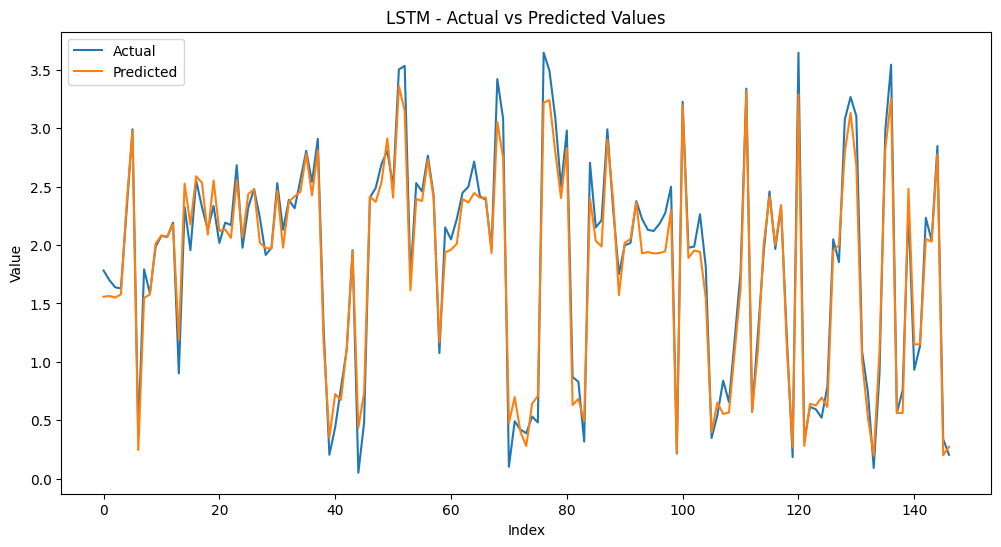

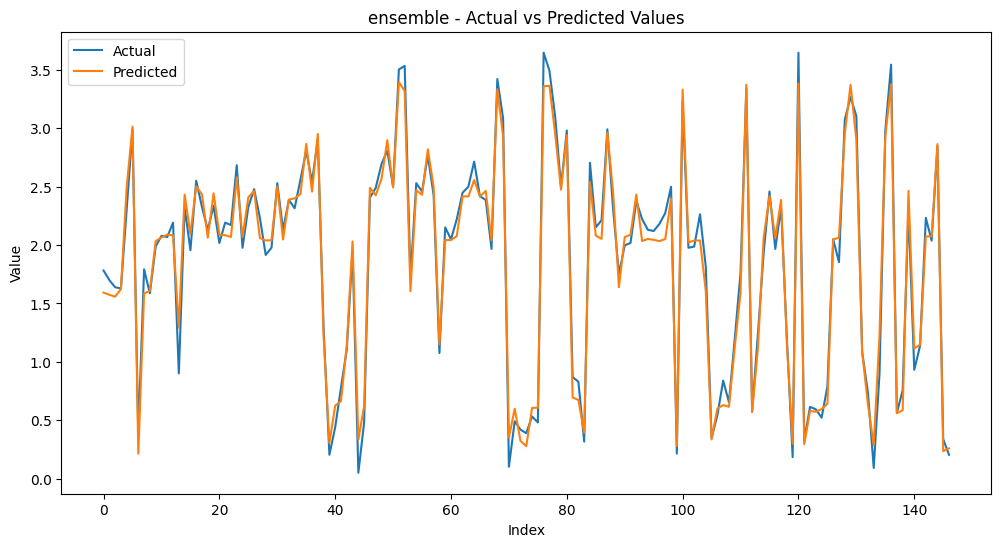

{'model': 'ensemble',
 'train_mae': 0.07665841095179479,
 'train_rmse': 0.0899473589263644,
 'test_mae': 0.10183301526265058,
 'test_rmse': 0.12389698226697764}

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def get_pred(X_train, X_test, model):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test

def get_result(model, y_train, y_test, y_pred_train, y_pred_test):
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Display plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_test, label='Predicted')
    plt.title(f'{model} - Actual vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    results = {
        'model': model,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }
    return results

# Linear Regression
def linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_train, y_pred_test = get_pred(X_train, X_test, model)
    results = get_result('linear regression', y_train, y_test, y_pred_train, y_pred_test)

    return y_pred_train, y_pred_test, results

# Random Forest
def random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred_train, y_pred_test = get_pred(X_train, X_test, model)
    results = get_result('random forest', y_train, y_test, y_pred_train, y_pred_test)

    return y_pred_train, y_pred_test, results

# Gradient Boosting
def gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=3):
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred_train, y_pred_test = get_pred(X_train, X_test, model)
    results = get_result('gradient boosting', y_train, y_test, y_pred_train, y_pred_test)

    return y_pred_train, y_pred_test, results

# LSTM
def lstm(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    # Reshaping the data
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Building the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fitting the model
    model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_train, y_pred_test = get_pred(X_train_reshaped, X_test_reshaped, model)
    results = get_result('LSTM', y_train, y_test, y_pred_train.flatten(), y_pred_test.flatten())

    return y_pred_train.flatten(), y_pred_test.flatten(), results

# Ensemble
def train_evaluate_ensemble_models(X_train, y_train, X_test, y_test):
    # Training and evaluating individual models
    lr_train_predictions, lr_test_predictions, lr_result = linear_regression(X_train, y_train, X_test, y_test)
    rf_train_predictions, rf_test_predictions, rf_result = random_forest(X_train, y_train, X_test, y_test)
    gb_train_predictions, gb_test_predictions, gb_result = gradient_boosting(X_train, y_train, X_test, y_test)
    lstm_train_predictions, lstm_test_predictions, lstm_result = lstm(X_train, y_train, X_test, y_test)

    # Averaging the predictions
    ensemble_train_predictions = np.mean([lr_train_predictions, rf_train_predictions, gb_train_predictions, lstm_train_predictions], axis=0)
    ensemble_test_predictions = np.mean([lr_test_predictions, rf_test_predictions, gb_test_predictions, lstm_test_predictions], axis=0)

    # Calculating MAE and RMSE for the ensemble
    ensemble_results = get_result('ensemble', y_train, y_test, ensemble_train_predictions, ensemble_test_predictions)

    return ensemble_results, lr_result, rf_result, gb_result, lstm_result

ensemble_results, lr_result, rf_result, gb_result, lstm_result = train_evaluate_ensemble_models(X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded)

ensemble_results


In [ ]:
# Note that the results of independent models can differ from before (cv_mae vs train_mae),
# because they are retrained

df_ensemble_results = pd.DataFrame.from_dict(ensemble_results, orient='index').T
df_lr_result = pd.DataFrame.from_dict(lr_result, orient='index').T
df_rf_result = pd.DataFrame.from_dict(rf_result, orient='index').T
df_gb_result = pd.DataFrame.from_dict(gb_result, orient='index').T
df_lstm_result = pd.DataFrame.from_dict(lstm_result, orient='index').T

df_result = pd.concat([df_lr_result, df_rf_result, df_gb_result, df_lstm_result, df_ensemble_results], ignore_index=True)
df_result

,model,train_mae,train_rmse,test_mae,test_rmse
0,linear regression,0.111489,0.130165,0.107439,0.126505
1,random forest,0.030937,0.049004,0.093946,0.141813
2,gradient boosting,0.066446,0.079217,0.09492,0.115789
3,LSTM,0.110327,0.133428,0.133758,0.169315
4,ensemble,0.076658,0.089947,0.101833,0.123897
